# Procedural Generation
#### Members: 
- Ghulame Mujtaba Arbi
- Bernard Lebeko Poulo
- Eric Ndirangu
- Coral Featherstone

#### Coaches:
- Ken Nixon
- James Wootton (remotely)

<font size='4'>In computing, procedural generation is a method of creating data algorithmically as opposed to manually, typically through a combination of human-generated assets and algorithms coupled with computer-generated randomness and processing power. In computer graphics, it is commonly used to create textures and 3D models. This notebook takes us through applying procedural generation on generating maps. </font>

In [1]:
from qiskit import *            # qiskit 
from noise import snoise2       # for perlin noise
import math
from tqdm import tqdm           # progress bar
import random

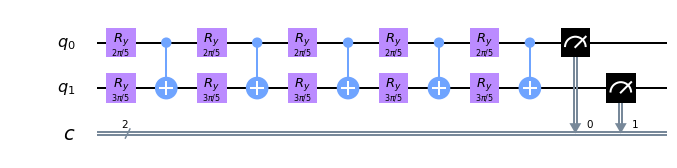

In [2]:
# Quantum circuit used in the procedural generation of the map that follows

from math import pi
seed=5

x, y = 2, 3

qc = QuantumCircuit(2,2)

# fill the circuits with gates that depend on x,y and seed
# (arbitrarily chosen)
for j in range(seed):
    qc.ry(x*pi/seed,0)
    qc.ry(y*pi/seed,1)
    qc.cx(0,1)
        
# put in some measure gates so we can get an output
qc.measure(0,0)
qc.measure(1,1)
    
qc.draw(output = 'mpl')

In [3]:

from qiskit import QuantumCircuit, execute, Aer
from math import pi
import numpy as np

def get_gradient( pos, seed=10 ):
    
    (x,y) = pos
    
    # initialize a circuit
    # arbitrarily chosen to have 2 qubits
    qc = QuantumCircuit(2,2)

    # fill the circuits with gates that depend on x,y and seed
    # (arbitrarily chosen)
    for j in range(seed):
        qc.ry(x*pi/seed,0)
        qc.ry(y*pi/seed,1)
        qc.cx(0,1)
        
    # put in some measure gates so we can get an output
    qc.measure(0,0)
    qc.measure(1,1)
    
    # run and get the counts dict
    counts = execute(qc,Aer.get_backend('qasm_simulator')).result().get_counts()

    # make sure that every possible output has a non-zero entry in the counts dict
    for output in ['00', '10', '11', '01']:
        if output not in counts:
            counts[output] = 1
            
    # use a couple of these numbers to define the 2D vector
    # (arbitrarily chosen to be the counts for 11 and 01
    print(counts)
    gradient = [counts['00'],counts['11'],counts['10'], counts['01']]
    # normalize the vector
    length = np.sqrt( gradient[0]**2 + gradient[1]**2 + gradient[2]**2 + gradient[3]**2)
    gradient = [ gradient[1]/length, gradient[3]/length ]
    
    # and output it
    return gradient

In [4]:
# display the x and 
g = get_gradient((2,3))
print(g)

{'00': 691, '01': 36, '10': 296, '11': 1}
[0.0013287420464791091, 0.04783471367324793]


<font size='4'> <b>Map Generation </b>: A map requires values over a 2d or 3d grid. It forms the space that a player occupies and interacts with. This will form the basis of what the layout would be.  </font> </br>

<font size='4'> <b>Perlin noise</b>: is a procedural texture primitive, a type of gradient noise used by visual effects artists to increase the appearance of realism in computer graphics. The function has a pseudo-random appearance, yet all of its visual details are the same size. This property allows it to be readily controllable; multiple scaled copies of Perlin noise can be inserted into mathematical expressions to create a great variety of procedural textures.</font>

In [5]:

class BaseMapGenerator:
    
    def __init__(self):    # Constructor of the class
        self.progress = 0;
        self.totalProgress = MapSize * MapSize;
        self.isFinished = False;
        self.pbar = tqdm(total = MapSize * MapSize);
        self.pbar.clear();
        self.smartGenerationEnabled = False;
        self.x = 0;
        self.y = 0;

    def GenPixel(self, x, y): # generate one pixel
        self.x += 1;
        if (self.x >= MapSize):
            self.x = 0;
            self.y += 1;
            if (self.y >= MapSize):
                self.isFinished = True;
                self.pbar.close();
        print(x + " " + y);
        
    def GenFull(self): # fully generate
        g = get_gradient((2,3))
        gradient3 = g[1]
        for x in range(0, MapSize):
            for y in range(0, MapSize):
                self.Generate(x,y,gradient3);



In [6]:
class MainMapGenerator(BaseMapGenerator): # gets base perlin height, make terrain and water
    
    def Generate(self, x, y, gradient3): 
        
        if (self.smartGenerationEnabled):
            self.x += 1
            if (self.x >= MapSize):
                self.x = 0;
                self.y += 1;
                if (self.y >= MapSize):
                    self.isFinished = True;
                    self.pbar.close()
        
        PerlinBaseValue = (snoise2(float(x)*perlinScale, float(y)*perlinScale, octaves=8, persistence=0.5, lacunarity=2.0, repeatx=2048, repeaty=2048, base=perlinOffset) + 1)/2.0

        # pixel height

        distance = DistanceNormalized(x,y, mapCenter[0], mapCenter[1], MapSize);

        PerlinBaseValue -= math.pow(distance, 0.5);
        if (PerlinBaseValue <= 0):
            PerlinBaseValue = 0

        heightMap[x][y] = PerlinBaseValue

        #pixel color

        if (heightMap[x][y] > landThreshold): #land

            detailPerlinValue = (snoise2(float(x)*perlinScale, float(y)*perlinScale, octaves=12, persistence=0.8, lacunarity=2.0, repeatx=2048, repeaty=2048, base=perlinOffset) + 1)/2.0;

            normalizedHeight = (detailPerlinValue - landThreshold);
            normalizedHeight *= normalizedHeight*normalizedHeight; # normalized height ^3

            noiseValue = (snoise2(float(x)*colorPerlinScale, float(y)*colorPerlinScale, octaves=2, persistence=0.5, lacunarity=2.0, repeatx=2048, repeaty=2048, base=perlinOffset) + 1)/2.0;
            randomColorOffset = (random.random()-0.5)*8 + 24.0*noiseValue + normalizedHeight*256.0;

            r = paperColor.r + randomColorOffset;
            g = paperColor.g + randomColorOffset;
            b = paperColor.b + randomColorOffset;
            colorMap[x][y].SetColor(r,g,b);

        else: #water

            normalizedHeight = (heightMap[x][y]);
            

            if (normalizedHeight < 0):
                normalizedHeight = 0;
            
            waterNoisePerlinScale = gradient3;

            noiseValue = (snoise2(float(x)*waterNoisePerlinScale, float(y)*waterNoisePerlinScale, octaves=2, persistence=0.5, lacunarity=2.0, repeatx=2048, repeaty=2048, base=perlinOffset) + 1)/2.0;
            randomColorOffset = (random.random()-0.5)*4 + 12.0*noiseValue + normalizedHeight*96.0;

            r = waterColor.r + randomColorOffset;
            g = waterColor.g + randomColorOffset;
            b = waterColor.b + randomColorOffset;

            if (r < 0):
                r = 0;
            if (g < 0):
                g = 0;
            if (b < 0):
                b = 0;

            colorMap[x][y].SetColor(r,g,b);

        self.pbar.update(1); #updates the progress bar



In [7]:
def Distance(ax = 0.0, ay = 0.0, bx = 0.0, by = 0.0):
    x = ax - bx;
    x *= x;
    y = ay - by;
    y*= y;
    return (math.sqrt(x + y));

def DistanceNormalized(ax = 0.0, ay = 0.0, bx = 0.0, by = 0.0, size = 256):
    dist = Distance(ax, ay, bx, by);
    dist /= size;
    return dist;

In [8]:
class Color:

    r = 0.0;
    g = 0.0;
    b = 0.0;
    a = 1.0;

    def __init__(self, r = 0.0, g = 0.0, b = 0.0):
        self.r = r;
        self.g = g;
        self.b = b;
        self.a = 1;
    def GetTuple(self):
        return (int(self.r),int(self.g),int(self.b));
    def SetColor(self, r, g, b):
        self.r = r;
        self.g = g;
        self.b = b;

        
paperColor = Color(212, 161, 104);
waterColor = Color(48, 86, 181);

In [9]:
import random

random.seed(1000)
perlinOffset = random.randint(25,500); # random offset

MapSize = 2048; # size in pixels
g = get_gradient((2,3))
perlinScale = g[0];

mapCenter = (MapSize/2, MapSize/2);

landThreshold = 0.1;

heightMap = [[0]*MapSize for x in range(MapSize)]
colorMap = [[Color() for j in range(MapSize)] for i in range(MapSize)]

randomColorRange = 10;
colorPerlinScale = g[1];


{'00': 655, '01': 42, '10': 320, '11': 7}


In [10]:
from PIL import Image


image = Image.new("RGB", (MapSize,MapSize))
targetGenerator = None

  0%|          | 12139/4194304 [00:00<01:34, 44464.75it/s]

Generating... 

{'00': 691, '01': 28, '10': 302, '11': 3}


100%|█████████▉| 4186554/4194304 [00:50<00:00, 84369.56it/s]



Generation finished. Saving output as Generated.png.


Displaying image output


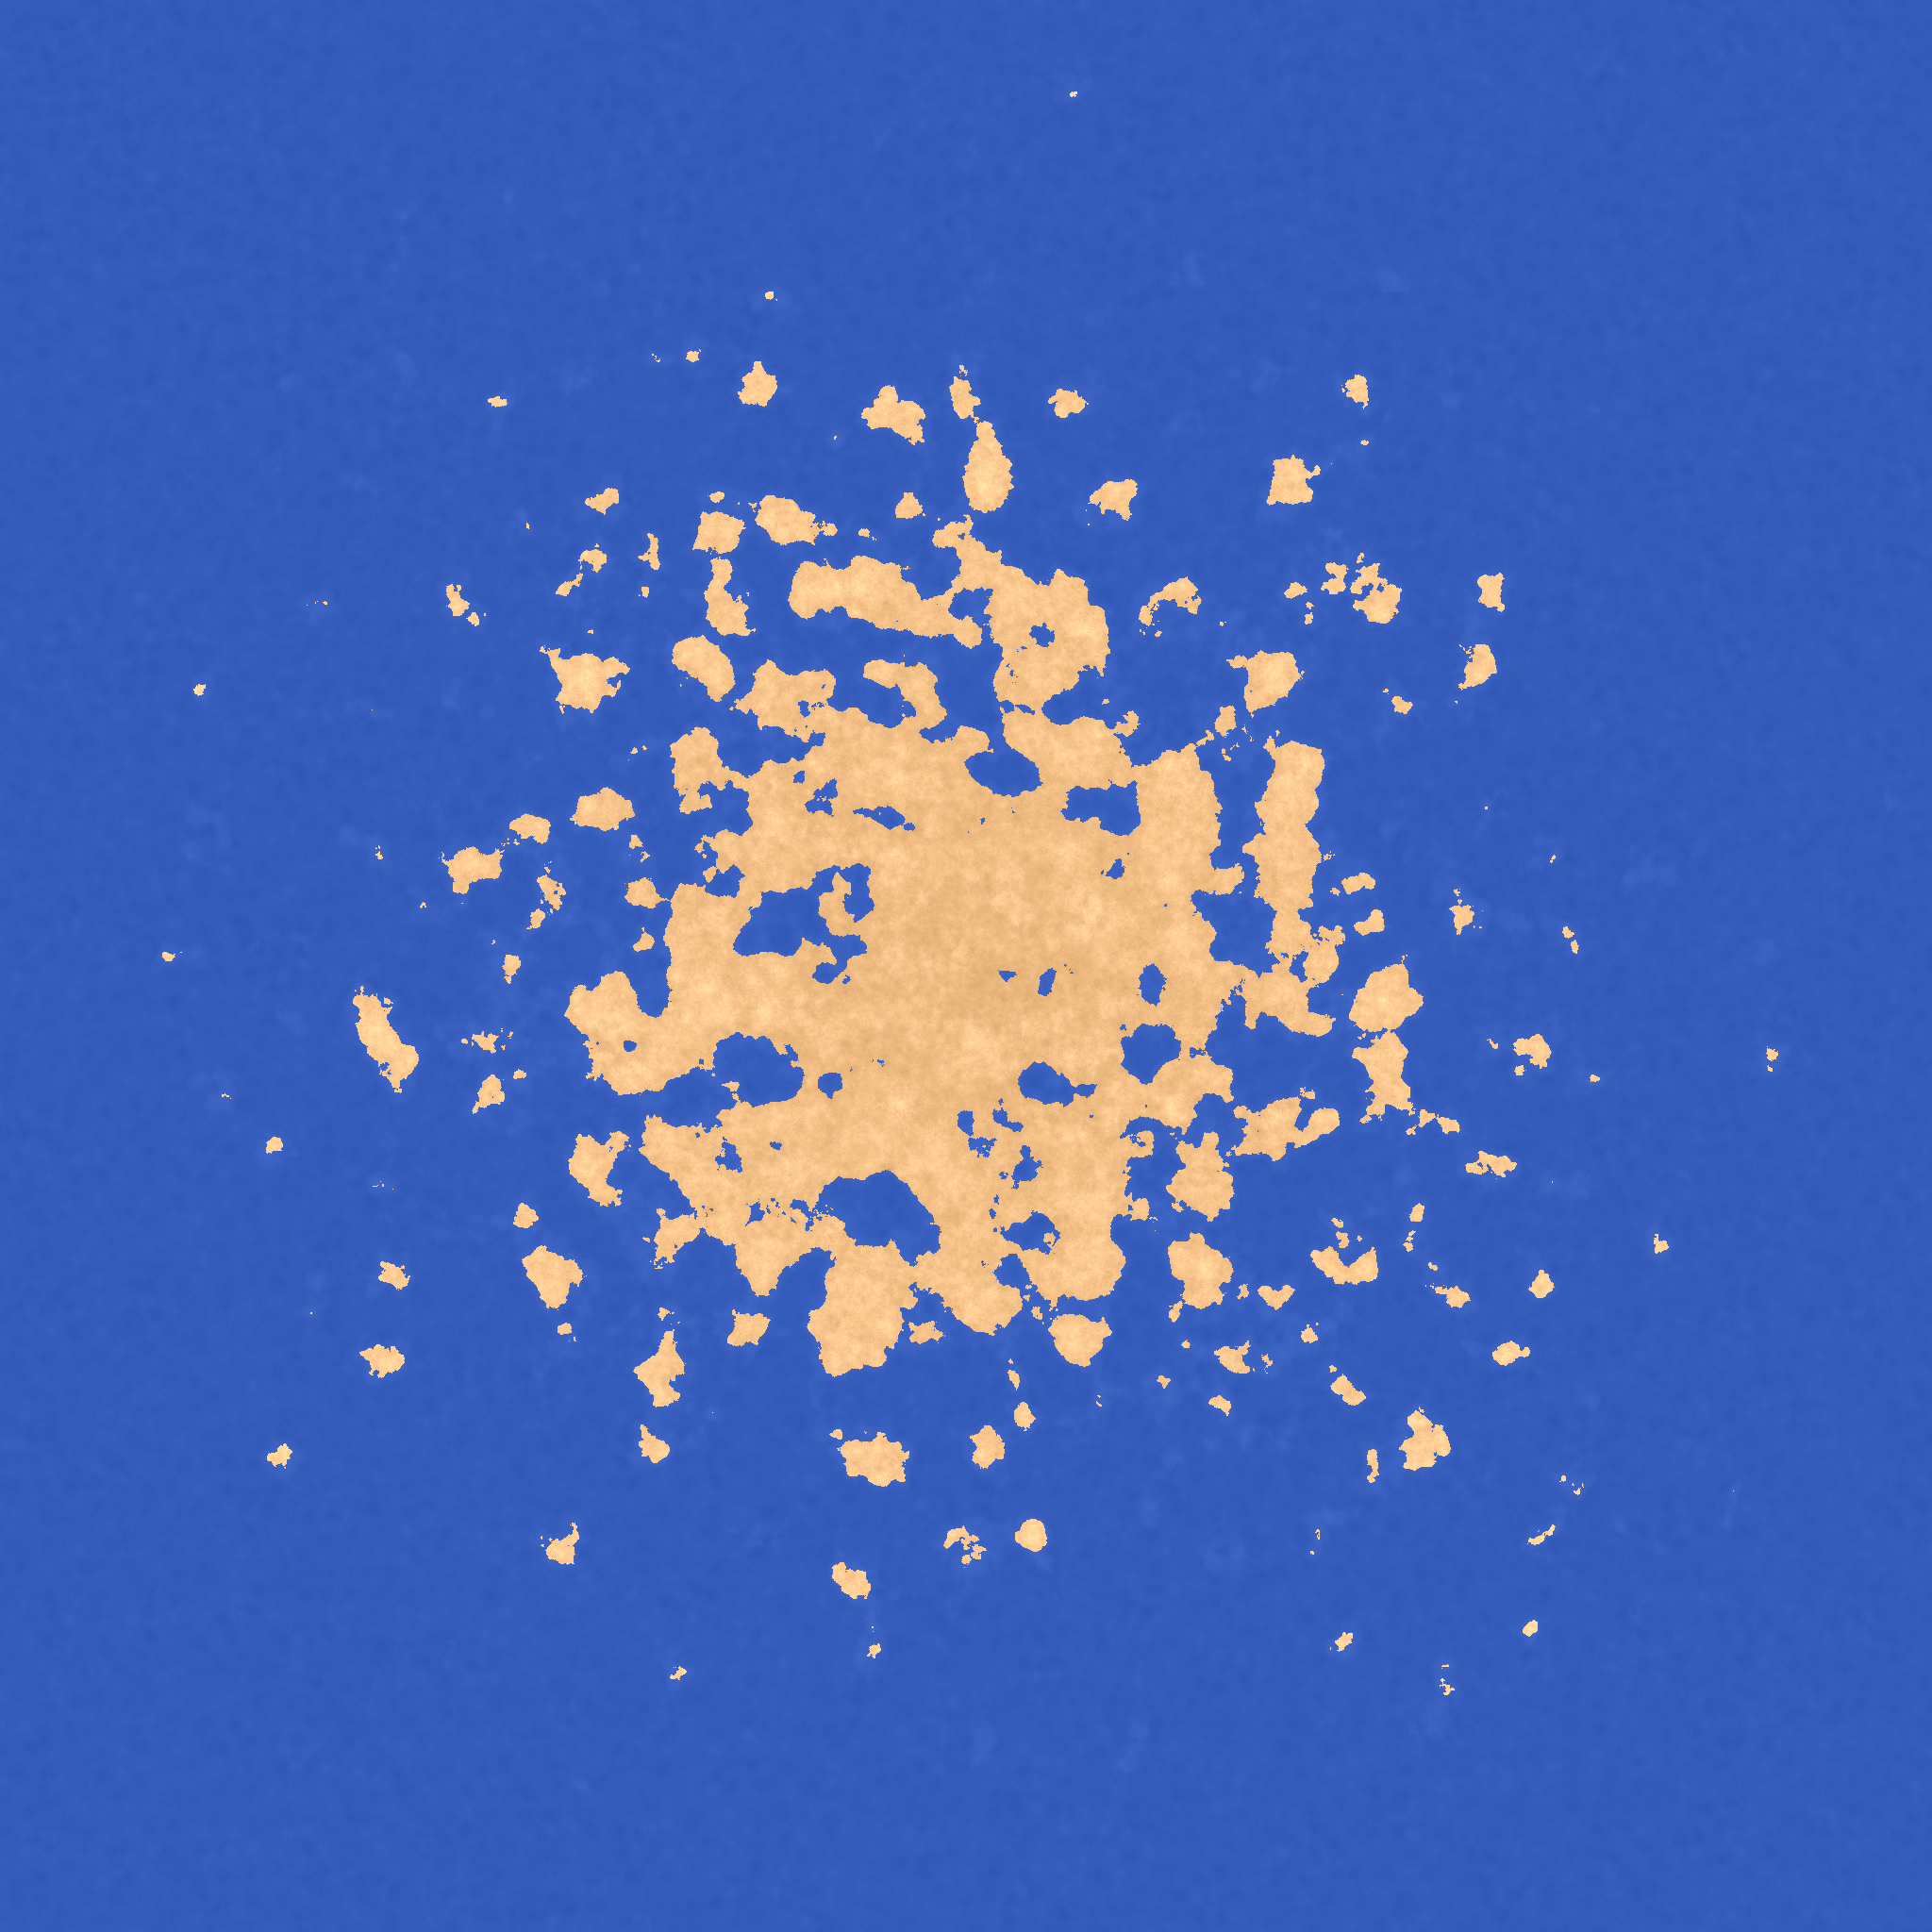

100%|██████████| 4194304/4194304 [01:10<00:00, 84369.56it/s]

In [11]:
from IPython.display import Image

targetGen = MainMapGenerator();

print("Generating... \n");

targetGen.GenFull();

print("\n\nGeneration finished. Saving output as Generated.png.");

for x in range(0, MapSize):
    for y in range(0, MapSize):
        image.putpixel((x,y), colorMap[x][y].GetTuple());

image.save("Generated.png");


# Displaying the image
print("\n\nDisplaying image output");
map_image = Image(filename='Generated.png')
display(map_image)

<font size='4'>  Quantum computation is a new architecture for computing. Once full-scale, fault-tolerant quantum computation is realized, it will provide a wide range of new algorithms to solve various problems in many different areas. These will provide significant reduction in computational complexity compared to algorithms for standard computers. For games, this means that many more different tasks will be acheivable within the timescale of a loading screen. </font>